# case 1

periodic

In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg
from jax.scipy.ndimage import map_coordinates
from typing import NamedTuple
import matplotlib.pyplot as plt

In [2]:
class FluidConfig:
    N_x = 128            #  (N x N)
    N_y = 128
    Lx = 1.0       # physical spatial scale. in previous code, spacial scale is not considered. that is, one cell with length 1
    Ly = 1.0
    dx = Lx / N_x  # in this code, we add the actually cell scale
    dy = Ly / N_y

    DT = 0.001 #0.01 # 0.05 #          # time step. change this if want different results
    VISCOSITY = 0.001             # Diffusion strength
    DIFFUSION_ITER = 20           # CG step for diffusion
    PRESSURE_ITER = 50            # CG step for pressure
    

class FluidState(NamedTuple): # define a state.
    u: jnp.ndarray     
    v: jnp.ndarray      
    density: jnp.ndarray 

In [3]:
def laplacian(f, dx,dy):
    '''
    laplacian operator by finite difference
    '''
    left  = jnp.roll(f, 1, axis=1)
    right = jnp.roll(f, -1, axis=1)
    down  = jnp.roll(f, 1, axis=0)
    up    = jnp.roll(f, -1, axis=0)
    la_x = (left - 2.0*f + right)/(dx*dx)
    la_y = (up - 2.0*f + down) / (dy*dy)
    return la_x+la_y

def divergence(u, v, dx, dy):
    '''
    divergence operator by finite difference
    '''
    du_dx = (jnp.roll(u, -1, axis=1) - jnp.roll(u, 1, axis=1)) / (2.0 * dx)
    dv_dy = (jnp.roll(v, -1, axis=0) - jnp.roll(v, 1, axis=0)) / (2.0 * dy)
    return du_dx + dv_dy

def gradient(p, dx, dy):
    '''
    gradient operator by finite difference. only for pressure p
    '''
    dp_dx = (jnp.roll(p, -1, axis=1) - jnp.roll(p, 1, axis=1)) / (2.0 * dx)
    dp_dy = (jnp.roll(p, -1, axis=0) - jnp.roll(p, 1, axis=0)) / (2.0 * dy)
    return dp_dx, dp_dy

In [4]:
def advect(f,u,v,dt,dx,dy):
    '''
    advection operator.
    
    f: the quantity to be advected. can be either velocity or scalar
    u, v: advect velocity
    '''
    mesh_y, mesh_x = jnp.meshgrid(jnp.arange(FluidConfig.N_y), jnp.arange(FluidConfig.N_x), indexing='ij')  # create mesh
    mesh_x_new = mesh_x - (u * dt) / dx    # trace older coordinates in x
    mesh_y_new = mesh_y - (v * dt) / dy    # trace older coordinates in y
    coords = jnp.stack([mesh_y_new, mesh_x_new], axis=0)  # combine x and y together
    return map_coordinates(f, coords, order=1, mode='wrap')  # interpolation

def diffuse(f,viscosity,dt, n_iter, dx, dy):
    '''
    diffuse operation

    f: the quantity to be diffused
    '''
    if viscosity == 0: # if viscosity is set to 0, directly return the unchanged field
        return f
    alpha = viscosity * dt # coefficient

    def linear_op(x):
        return x - alpha * laplacian(x, dx, dy) # forms an operator

    f_new, _ = cg(linear_op, f, maxiter=n_iter) # solved by built-in CG solver
    return f_new

def pressure(div, n_iter, dx, dy):
    '''
    solve the possion equation

    div: divergence of the velocity field
    n_iter: CG steps maximum
    '''
    def laplacian_op(p):
        return laplacian(p, dx, dy)
    p, _ = cg(laplacian_op, div, maxiter=n_iter)
    return p

def project(u, v, n_iter, dx, dy):
    '''
    projection
    '''
    div = divergence(u, v, dx, dy) # calculate divergence
    p = pressure(div, n_iter, dx, dy) # use the divergence to solve for pressure
    grad_p_x, grad_p_y = gradient(p, dx, dy) # gradient of pressure
    return u - grad_p_x, v - grad_p_y # update

In [5]:
@jax.jit
def step_fn(state: FluidState) -> FluidState:
    u, v, dens = state.u, state.v, state.density
   
    # No Forcing 
    u_forced, v_forced = u, v

    # Self-advection
    u_adv = advect(u_forced, u_forced, v_forced, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy)
    v_adv = advect(v_forced, u_forced, v_forced, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy)
    
    #  Diffusion 
    u_diff = diffuse(u_adv, FluidConfig.VISCOSITY, FluidConfig.DT, FluidConfig.DIFFUSION_ITER, FluidConfig.dx, FluidConfig.dy)
    v_diff = diffuse(v_adv, FluidConfig.VISCOSITY, FluidConfig.DT, FluidConfig.DIFFUSION_ITER, FluidConfig.dx, FluidConfig.dy)
    
    
    # Projection 
    u_final, v_final = project(u_diff, v_diff, FluidConfig.PRESSURE_ITER, FluidConfig.dx, FluidConfig.dy)

    # density-advection
    dens_adv = advect(dens, u_final, v_final, FluidConfig.DT, FluidConfig.dx, FluidConfig.dy)
    
    return FluidState(u_final, v_final, dens_adv)

In [6]:
def init_checkerboard_shear():
    '''
    initialize the velocity field and scalar field
    return a state
    '''
    y, x = jnp.meshgrid(jnp.arange(FluidConfig.N_y), jnp.arange(FluidConfig.N_x), indexing='ij')
    
    cy, cx = FluidConfig.N_y // 2, FluidConfig.N_x // 2
    
    density = jnp.zeros((FluidConfig.N_y, FluidConfig.N_x))
    
    density = density.at[cy:, :cx].set(1.0)   # Top-Left
    density = density.at[cy:, cx:].set(0.66)  # Top-Right
    density = density.at[:cy, :cx].set(0.33)  # Bottom-Left
    density = density.at[:cy, cx:].set(0.0)   # Bottom-Right
    
    is_top = y >= cy
    is_right = x >= cx
    
    positive_mask = (is_top & ~is_right) | (~is_top & is_right)
    
    U_MAG = 2.0
    u = jnp.where(positive_mask, U_MAG, -U_MAG)
    v = jnp.zeros((FluidConfig.N_y, FluidConfig.N_x))
    
    key = jax.random.PRNGKey(101)
    k1, k2 = jax.random.split(key, 2)
    noise_u = jax.random.normal(k1, (FluidConfig.N_y, FluidConfig.N_x)) * NOISE_SCALE
    noise_v = jax.random.normal(k2, (FluidConfig.N_y, FluidConfig.N_x)) * NOISE_SCALE
    
    u = u + noise_u
    v = v + noise_v
    
    return FluidState(u, v, density)

Generating 24 snapshots...


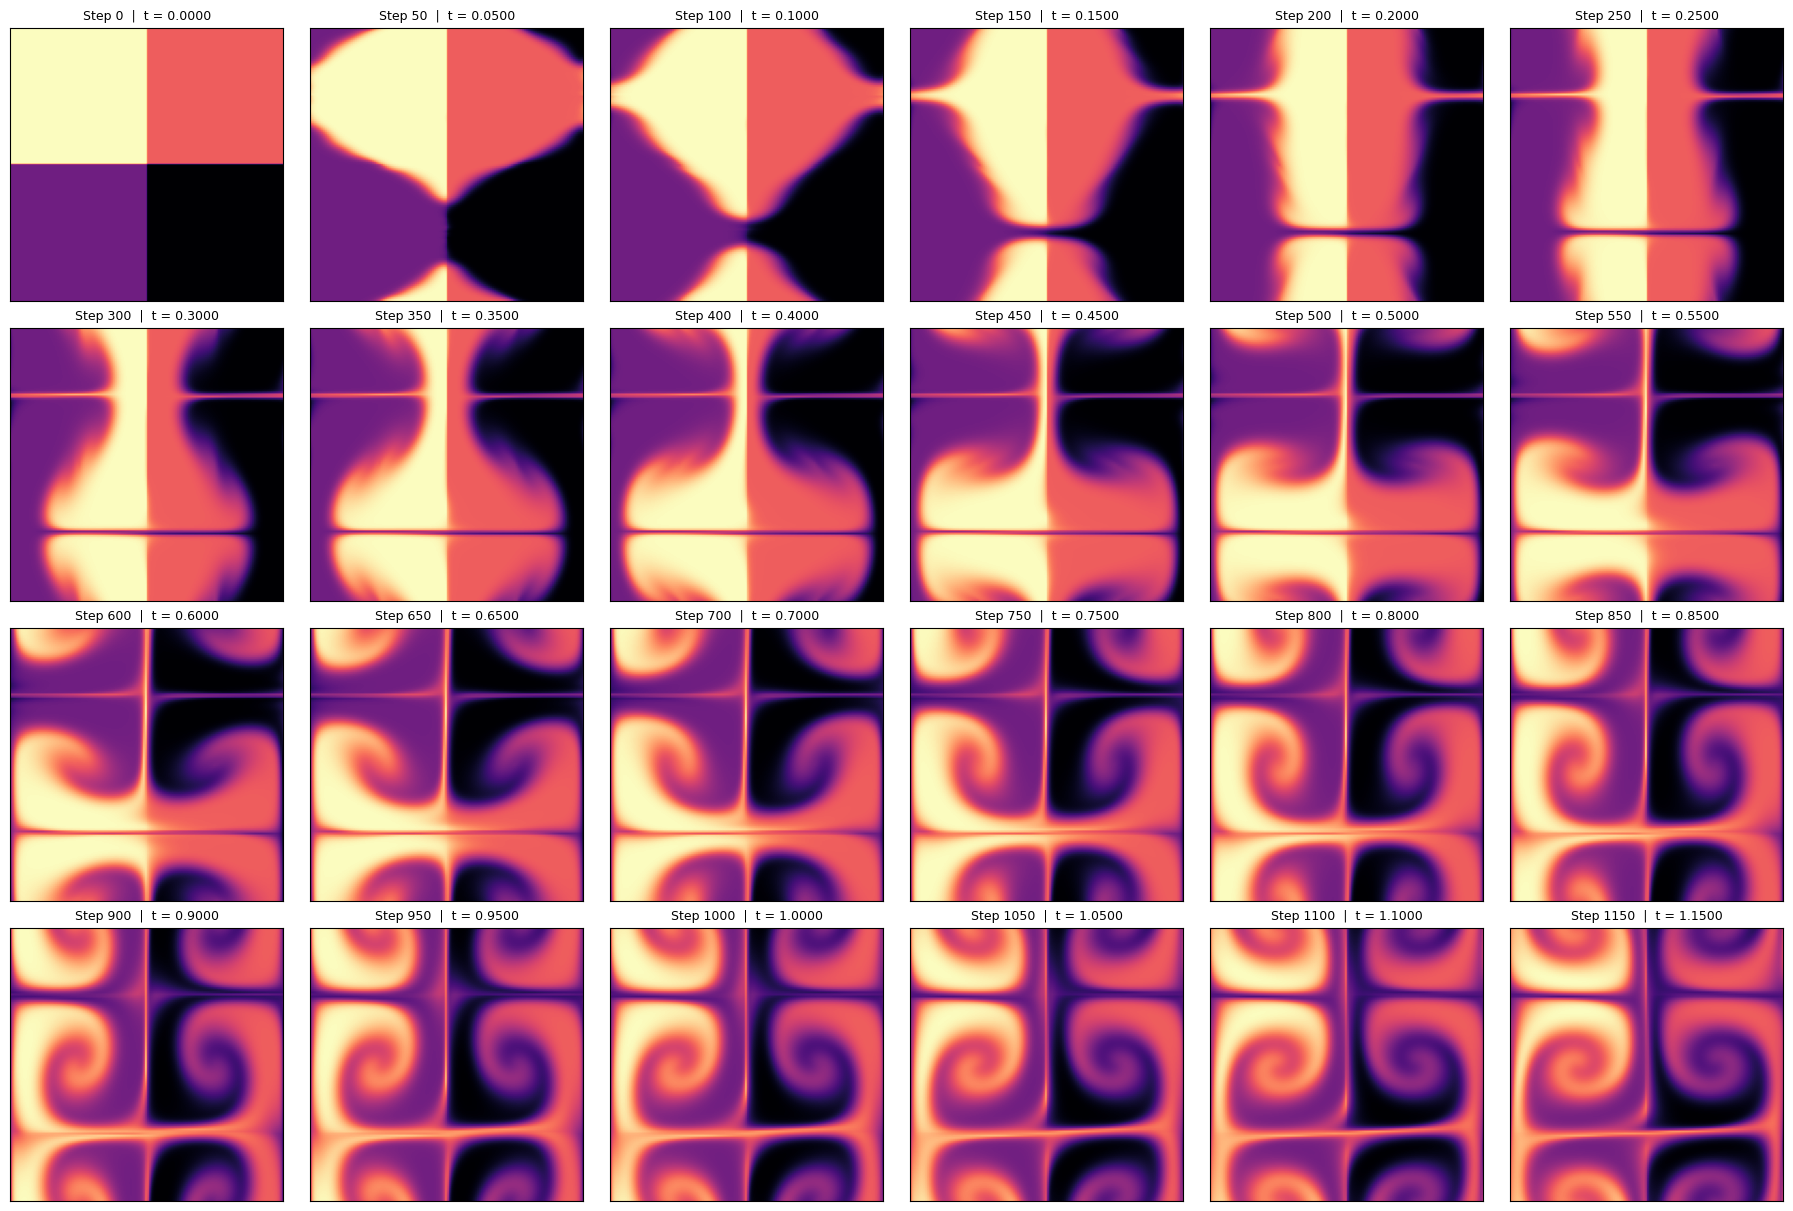

In [7]:
import matplotlib.pyplot as plt
import jax
NOISE_SCALE = 0.2

def main_grid_plot():
    state0 = init_checkerboard_shear()
    # initial compile
    _ = step_fn(state0)

    # real state
    state = init_checkerboard_shear()
    
    rows = 4
    cols = 6
    total_plots = rows * cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 12), constrained_layout=True)
    
    axes_flat = axes.flatten()
    
    steps_per_plot =  50 #5 #1 #  改变步数 对应前面时间步同步调整
    current_step = 0
    
    print(f"Generating {total_plots} snapshots...")

    for i, ax in enumerate(axes_flat):
        
        n_steps = 0 if i == 0 else steps_per_plot
        
        for _ in range(n_steps):
            state = step_fn(state)
            current_step += 1
            
        data = jax.device_get(state.density)
        ax.imshow(data, cmap='magma', origin='lower')#, vmin=0, vmax=1)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        t = current_step * FluidConfig.DT
        ax.set_title(f"Step {current_step}  |  t = {t:.4f}", fontsize=9)

    plt.savefig("case_1_dt_0p001_3.png", dpi=300, bbox_inches='tight')
    plt.show()

main_grid_plot()